**Feature Engineering**   
Fintech 540 - Machine Learning  
Project - Group 6

**Initial Data:** RV_March2024.xlsx 

**Objective:**  
Transform raw volatility measures into a feature-rich dataset for predictive modeling.

**Data Source:**  
- 30 Dow Jones stocks
- 5,346 trading days (2003-2024)
- 10 volatility measures per stock (RV, BPV, Good, Bad, RQ at 1-min and 5-min frequencies)

**Feature Engineering Strategy:**
1. **Temporal Features**: Lags, rolling statistics, momentum indicators
2. **Cross-Sectional Features**: Relative volatility, market-wide measures
3. **Variance Decomposition Features**: Jump indicators, continuous vs discontinuous ratios
4. **Frequency Features**: 1-min vs 5-min relationships
5. **Data Quality Features**: Missing data indicators, data availability flags
 
**Output:**  
Clean, feature-rich dataset ready for machine learning models.


**1. Environment Setup and Data Loading**

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("-"*70)
print("FEATURE ENGINEERING PIPELINE - RV MARCH 2024")
print("-"*70)

----------------------------------------------------------------------
FEATURE ENGINEERING PIPELINE - RV MARCH 2024
----------------------------------------------------------------------


**2. Load Raw Data**  
We load all sheets from the Excel file and structure them properly. Missing data (encoded as zeros) will be handled explicitly in the feature engineering process.


In [3]:
# Load reference sheets
dates_df = pd.read_excel("../data/RV_March2024.xlsx", sheet_name="Dates", header=None)
companies_df = pd.read_excel("../data/RV_March2024.xlsx", sheet_name="Companies", header=None)

# Get lists for iteration
dates_list = pd.to_datetime(dates_df[0], format='%d-%b-%Y')
companies_list = companies_df[0].tolist()

print(f"Data Period: {dates_list.min().date()} to {dates_list.max().date()}")
print(f"Number of trading days: {len(dates_list)}")
print(f"Number of companies: {len(companies_list)}")
print(f"\nCompanies: {', '.join(companies_list)}")

# Load all volatility measure sheets
sheet_names = ['RV', 'BPV', 'Good', 'Bad', 'RQ', 'RV_5', 'BPV_5', 'Good_5', 'Bad_5', 'RQ_5']
data_dict = {}

print(f"\nLoading {len(sheet_names)} data sheets...")
for sheet in sheet_names:
    df = pd.read_excel("../data/RV_March2024.xlsx", sheet_name=sheet, header=None)
    df.columns = companies_list
    df.index = dates_list
    df.index.name = 'Date'
    data_dict[sheet] = df
    print(f"  ✓ {sheet:8s}: {df.shape}")

print("\nData loaded successfully!")


Data Period: 2003-01-02 to 2024-03-28
Number of trading days: 5346
Number of companies: 30

Companies: AAPL, AMGN, AMZN, AXP, BA, CAT, CRM, CSCO, CVX, DIS, DOW, GS, HD, HON, IBM, INTC, JNJ, JPM, KO, MCD, MMM, MRK, MSFT, NKE, PG, TRV, UNH, V, VZ, WMT

Loading 10 data sheets...
  ✓ RV      : (5346, 30)
  ✓ BPV     : (5346, 30)
  ✓ Good    : (5346, 30)
  ✓ Bad     : (5346, 30)
  ✓ RQ      : (5346, 30)
  ✓ RV_5    : (5346, 30)
  ✓ BPV_5   : (5346, 30)
  ✓ Good_5  : (5346, 30)
  ✓ Bad_5   : (5346, 30)
  ✓ RQ_5    : (5346, 30)

Data loaded successfully!


**3. Data Preprocessing and Cleaning**  
Key Steps:
- Replace zeros with NaN (missing data encoding)
- Create a master dataset combining all measures
- Handle missing data systematically
- Validate data integrity

In [6]:
# Replace zeros with NaN across all sheets
print("\n" + "-"*70)
print("DATA PREPROCESSING")
print("-"*70)

for sheet_name, df in data_dict.items():
    data_dict[sheet_name] = df.replace(0, np.nan)
    missing_pct = (df.isna().sum().sum() / (df.shape[0] * df.shape[1])) * 100
    print(f"{sheet_name:8s}: {missing_pct:.2f}% missing data")

# Create long-format master dataset
print("\nCreating master dataset in long format...")

master_data = []
for ticker in companies_list:
    ticker_data = pd.DataFrame({
        'Date': dates_list,
        'Ticker': ticker
    })
    
    # Add all measures for this ticker
    for sheet_name in sheet_names:
        ticker_data[sheet_name] = data_dict[sheet_name][ticker].values
    
    master_data.append(ticker_data)

df_master = pd.concat(master_data, ignore_index=True)

print(f"\nMaster dataset created: {df_master.shape}")
print(f"Total observations: {len(df_master):,}")
print(f"Features: Date, Ticker + {len(sheet_names)} volatility measures")

# Display sample
print("\nSample of master dataset:")
print(df_master.head(10))


----------------------------------------------------------------------
DATA PREPROCESSING
----------------------------------------------------------------------
RV      : 4.24% missing data
BPV     : 4.26% missing data
Good    : 4.24% missing data
Bad     : 4.24% missing data
RQ      : 4.24% missing data
RV_5    : 4.24% missing data
BPV_5   : 4.24% missing data
Good_5  : 4.24% missing data
Bad_5   : 4.24% missing data
RQ_5    : 4.24% missing data

Creating master dataset in long format...

Master dataset created: (160380, 12)
Total observations: 160,380
Features: Date, Ticker + 10 volatility measures

Sample of master dataset:
        Date Ticker       RV     BPV    Good     Bad        RQ    RV_5  \
0 2003-01-02   AAPL   8.3082  6.2018  5.4820  2.8262  263.0252  6.4939   
1 2003-01-03   AAPL   6.5682  5.3314  3.3633  3.2048   98.4764  6.5745   
2 2003-01-06   AAPL   7.3444  6.1792  3.8547  3.4897  301.8829  5.9923   
3 2003-01-07   AAPL  10.0133  9.1303  5.5418  4.4715  215.2682  9.50

In [7]:
df_master

,Date,Ticker,RV,BPV,Good,Bad,RQ,RV_5,BPV_5,Good_5,Bad_5,RQ_5
0,2003-01-02,AAPL,8.3082,6.2018,5.4820,2.8262,263.0252,6.4939,3.7720,5.1023,1.3916,152.7294
1,2003-01-03,AAPL,6.5682,5.3314,3.3633,3.2048,98.4764,6.5745,5.8933,3.6380,2.9365,62.0543
2,2003-01-06,AAPL,7.3444,6.1792,3.8547,3.4897,301.8829,5.9923,4.4432,3.8791,2.1132,180.2133
3,2003-01-07,AAPL,10.0133,9.1303,5.5418,4.4715,215.2682,9.5007,7.1200,5.7827,3.7179,197.3819
4,2003-01-08,AAPL,6.0982,4.9211,3.2482,2.8500,97.9670,4.9405,5.4333,2.4732,2.4674,35.7264
...,...,...,...,...,...,...,...,...,...,...,...,...
160375,2024-03-22,WMT,0.5350,0.4092,0.2549,0.2800,1.3144,0.4101,0.3899,0.1622,0.2478,0.2477
160376,2024-03-25,WMT,0.6223,0.5255,0.2983,0.3240,0.7816,0.5458,0.5431,0.2363,0.3095,0.2871
160377,2024-03-26,WMT,0.6235,0.4772,0.3023,0.3213,1.8720,0.5238,0.5012,0.2955,0.2283,0.5659
160378,2024-03-27,WMT,0.4281,0.3431,0.2193,0.2088,0.3398,0.4057,0.4784,0.1935,0.2123,0.1592


**4. Feature Creation - Temporal Features**

Temporal features capture time-series dynamics:  
- **Lags**: Past values (t-1, t-5, t-20)  
- **Rolling statistics**: Moving averages, standard deviations  
- **Momentum**: Rate of change indicators  
- **Trend**: Direction and strength of volatility trends  


In [8]:
print("\n" + "="*70)
print("CREATING TEMPORAL FEATURES")
print("="*70)

# Sort by ticker and date for proper time series operations
df_master = df_master.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Define lag periods
lag_periods = [1, 5, 10, 20]  # 1 day, 1 week, 2 weeks, 1 month

# Define rolling windows
rolling_windows = [5, 20, 60]  # 1 week, 1 month, 3 months

# Create lag features for RV (primary target)
print("\nCreating lag features for RV...")
for lag in lag_periods:
    df_master[f'RV_lag{lag}'] = df_master.groupby('Ticker')['RV'].shift(lag)
    print(f"  ✓ RV_lag{lag}")

# Create rolling statistics
print("\nCreating rolling statistics...")
for window in rolling_windows:
    # Rolling mean
    df_master[f'RV_roll_mean_{window}'] = (
        df_master.groupby('Ticker')['RV']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )
    
    # Rolling std
    df_master[f'RV_roll_std_{window}'] = (
        df_master.groupby('Ticker')['RV']
        .transform(lambda x: x.rolling(window=window, min_periods=1).std())
    )
    
    # Rolling min/max
    df_master[f'RV_roll_min_{window}'] = (
        df_master.groupby('Ticker')['RV']
        .transform(lambda x: x.rolling(window=window, min_periods=1).min())
    )
    
    df_master[f'RV_roll_max_{window}'] = (
        df_master.groupby('Ticker')['RV']
        .transform(lambda x: x.rolling(window=window, min_periods=1).max())
    )
    
    print(f"  ✓ Rolling features (window={window})")

# Momentum features
print("\nCreating momentum features...")
df_master['RV_momentum_5'] = df_master['RV'] / df_master['RV_lag5'] - 1
df_master['RV_momentum_20'] = df_master['RV'] / df_master['RV_lag20'] - 1

# Volatility of volatility
df_master['RV_volatility_20'] = (
    df_master.groupby('Ticker')['RV']
    .transform(lambda x: x.rolling(window=20, min_periods=1).std())
)

print(f"\nTotal temporal features created: {len([c for c in df_master.columns if 'lag' in c or 'roll' in c or 'momentum' in c])}")



CREATING TEMPORAL FEATURES

Creating lag features for RV...
  ✓ RV_lag1
  ✓ RV_lag5
  ✓ RV_lag10
  ✓ RV_lag20

Creating rolling statistics...
  ✓ Rolling features (window=5)
  ✓ Rolling features (window=20)
  ✓ Rolling features (window=60)

Creating momentum features...

Total temporal features created: 18


**5. Feature Creation - Variance Decomposition Features**
**Decomposition features leverage the Good/Bad variance split:
- **Jump indicators**: Bad variance relative to total
- **Continuous component strength**: Good variance ratios
- **Jump detection signals**: Threshold-based indicators

In [9]:
print("\n" + "="*70)
print("CREATING VARIANCE DECOMPOSITION FEATURES")
print("="*70)

# Good/Bad variance ratios
print("\nCreating variance decomposition ratios...")

df_master['Good_Bad_ratio'] = df_master['Good'] / df_master['Bad']
df_master['Bad_pct'] = df_master['Bad'] / df_master['RV']
df_master['Good_pct'] = df_master['Good'] / df_master['RV']

# Verify decomposition (should be close to 1.0)
df_master['decomp_check'] = (df_master['Good'] + df_master['Bad']) / df_master['RV']

print("  ✓ Good/Bad ratios")
print("  ✓ Bad percentage (jump indicator)")
print("  ✓ Good percentage (continuous component)")

# Jump detection features
print("\nCreating jump detection features...")

# Define jump threshold (Bad variance > 20% of total)
JUMP_THRESHOLD = 0.20

df_master['jump_indicator'] = (df_master['Bad_pct'] > JUMP_THRESHOLD).astype(int)

# Rolling jump frequency
df_master['jump_freq_20'] = (
    df_master.groupby('Ticker')['jump_indicator']
    .transform(lambda x: x.rolling(window=20, min_periods=1).mean())
)

# Jump intensity
df_master['jump_intensity'] = df_master['Bad'] * df_master['jump_indicator']

print(f"  ✓ Jump indicator (threshold={JUMP_THRESHOLD})")
print(f"  ✓ Rolling jump frequency")
print(f"  ✓ Jump intensity")

# Compare 1-min vs 5-min decomposition
print("\nCreating cross-frequency decomposition features...")

df_master['Bad_pct_5'] = df_master['Bad_5'] / df_master['RV_5']
df_master['jump_diff_freq'] = df_master['Bad_pct'] - df_master['Bad_pct_5']

print("  ✓ Cross-frequency jump comparison")

print(f"\nTotal decomposition features: {len([c for c in df_master.columns if 'Good' in c or 'Bad' in c or 'jump' in c])}")



CREATING VARIANCE DECOMPOSITION FEATURES

Creating variance decomposition ratios...
  ✓ Good/Bad ratios
  ✓ Bad percentage (jump indicator)
  ✓ Good percentage (continuous component)

Creating jump detection features...
  ✓ Jump indicator (threshold=0.2)
  ✓ Rolling jump frequency
  ✓ Jump intensity

Creating cross-frequency decomposition features...
  ✓ Cross-frequency jump comparison

Total decomposition features: 12


6. Feature Creation - Cross-Sectional Features
   
**Cross-sectional features compare a stock's volatility to the market:**
- **Relative volatility**: Stock RV vs market average
- **Volatility rank**: Percentile ranking among stocks
- **Market-wide measures**: Average, median, spread across all stocks

In [10]:
print("\n" + "="*70)
print("CREATING CROSS-SECTIONAL FEATURES")
print("="*70)

# Calculate market-wide statistics for each date
print("\nCalculating market-wide statistics...")

market_stats = df_master.groupby('Date').agg({
    'RV': ['mean', 'median', 'std', 'min', 'max'],
    'Bad_pct': ['mean', 'median'],
    'jump_indicator': 'sum'
}).reset_index()

# Flatten column names
market_stats.columns = ['Date', 'market_RV_mean', 'market_RV_median', 
                        'market_RV_std', 'market_RV_min', 'market_RV_max',
                        'market_Bad_pct_mean', 'market_Bad_pct_median',
                        'market_jump_count']

# Merge back to main dataset
df_master = df_master.merge(market_stats, on='Date', how='left')

print("  ✓ Market-wide RV statistics")
print("  ✓ Market-wide jump statistics")

# Relative volatility features
print("\nCreating relative volatility features...")

df_master['RV_vs_market'] = df_master['RV'] / df_master['market_RV_mean']
df_master['RV_zscore'] = ((df_master['RV'] - df_master['market_RV_mean']) / 
                          df_master['market_RV_std'])

# Volatility rank (percentile)
df_master['RV_rank'] = (
    df_master.groupby('Date')['RV']
    .rank(pct=True)
)

print("  ✓ Relative volatility vs market")
print("  ✓ Volatility z-score")
print("  ✓ Volatility rank (percentile)")

# Market dispersion
df_master['market_dispersion'] = df_master['market_RV_max'] - df_master['market_RV_min']
df_master['market_CV'] = df_master['market_RV_std'] / df_master['market_RV_mean']

print("  ✓ Market dispersion measures")

print(f"\nTotal cross-sectional features: {len([c for c in df_master.columns if 'market' in c or 'rank' in c or 'vs_market' in c])}")



CREATING CROSS-SECTIONAL FEATURES

Calculating market-wide statistics...
  ✓ Market-wide RV statistics
  ✓ Market-wide jump statistics

Creating relative volatility features...
  ✓ Relative volatility vs market
  ✓ Volatility z-score
  ✓ Volatility rank (percentile)
  ✓ Market dispersion measures

Total cross-sectional features: 12


**7. Feature Creation - Frequency Relationship Features**

**Leverage the relationship between 1-min and 5-min measures:**
- **Microstructure noise**: 1-min vs 5-min differences
- **Frequency ratios**: How measures scale across frequencies
- **Consistency indicators**: Agreement between frequencies


In [11]:
print("\n" + "="*70)
print("CREATING FREQUENCY RELATIONSHIP FEATURES")
print("="*70)

# 1-min vs 5-min ratios
print("\nCreating frequency ratio features...")

df_master['RV_freq_ratio'] = df_master['RV'] / df_master['RV_5']
df_master['BPV_freq_ratio'] = df_master['BPV'] / df_master['BPV_5']
df_master['Good_freq_ratio'] = df_master['Good'] / df_master['Good_5']
df_master['Bad_freq_ratio'] = df_master['Bad'] / df_master['Bad_5']

print("  ✓ RV frequency ratio (1-min/5-min)")
print("  ✓ BPV frequency ratio")
print("  ✓ Good/Bad frequency ratios")

# Microstructure noise indicator
# Theory: excess RV at 1-min suggests noise
df_master['microstructure_noise'] = df_master['RV'] - df_master['RV_5']

# Frequency consistency
df_master['freq_consistency'] = np.abs(1 - df_master['RV_freq_ratio'])

print("  ✓ Microstructure noise estimate")
print("  ✓ Frequency consistency measure")

print(f"\nTotal frequency features: {len([c for c in df_master.columns if 'freq' in c or 'microstructure' in c])}")



CREATING FREQUENCY RELATIONSHIP FEATURES

Creating frequency ratio features...
  ✓ RV frequency ratio (1-min/5-min)
  ✓ BPV frequency ratio
  ✓ Good/Bad frequency ratios
  ✓ Microstructure noise estimate
  ✓ Frequency consistency measure

Total frequency features: 8


**8. Feature Creation - Calendar and Time Features**

**Time-based features can capture seasonality and patterns:**
- **Day of week**: Monday effect, Friday effect
- **Month**: Seasonal patterns
- **Quarter**: Quarterly earnings effects
- **Year**: Long-term trends


In [12]:
print("\n" + "="*70)
print("CREATING CALENDAR FEATURES")
print("="*70)

# Extract time components
df_master['year'] = df_master['Date'].dt.year
df_master['month'] = df_master['Date'].dt.month
df_master['quarter'] = df_master['Date'].dt.quarter
df_master['day_of_week'] = df_master['Date'].dt.dayofweek  # Monday=0, Sunday=6
df_master['day_of_month'] = df_master['Date'].dt.day
df_master['week_of_year'] = df_master['Date'].dt.isocalendar().week

print("  ✓ Year, Month, Quarter")
print("  ✓ Day of week, Day of month")
print("  ✓ Week of year")

# Is Monday/Friday (known volatility patterns)
df_master['is_monday'] = (df_master['day_of_week'] == 0).astype(int)
df_master['is_friday'] = (df_master['day_of_week'] == 4).astype(int)

# Month-end effect (last 3 days of month)
df_master['is_month_end'] = (df_master['day_of_month'] >= 28).astype(int)

print("  ✓ Monday/Friday indicators")
print("  ✓ Month-end indicator")

print(f"\nTotal calendar features: {len([c for c in df_master.columns if c in ['year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'week_of_year', 'is_monday', 'is_friday', 'is_month_end']])}")



CREATING CALENDAR FEATURES
  ✓ Year, Month, Quarter
  ✓ Day of week, Day of month
  ✓ Week of year
  ✓ Monday/Friday indicators
  ✓ Month-end indicator

Total calendar features: 9


**9. Feature Creation - Data Quality Features**

**Track data availability and quality:**
- **Missing data indicators**: Whether original data was missing
- **Data completeness scores**: How much recent data is available
- **Imputation flags**: Mark imputed values

In [13]:
print("\n" + "="*70)
print("CREATING DATA QUALITY FEATURES")
print("="*70)

# Create missingness indicators (before any imputation)
print("\nCreating missingness indicators...")

df_master['RV_is_missing'] = df_master['RV'].isna().astype(int)
df_master['BPV_is_missing'] = df_master['BPV'].isna().astype(int)
df_master['Good_is_missing'] = df_master['Good'].isna().astype(int)
df_master['Bad_is_missing'] = df_master['Bad'].isna().astype(int)

# Data completeness score (% of non-missing in last 20 days)
df_master['data_completeness_20'] = (
    df_master.groupby('Ticker')['RV_is_missing']
    .transform(lambda x: 1 - x.rolling(window=20, min_periods=1).mean())
)

print("  ✓ Missingness indicators for key measures")
print("  ✓ Data completeness score (20-day)")

# Consecutive missing days
df_master['consec_missing'] = (
    df_master.groupby('Ticker')['RV_is_missing']
    .transform(lambda x: x.groupby((x != x.shift()).cumsum()).cumsum())
)

print("  ✓ Consecutive missing days counter")

print(f"\nTotal data quality features: {len([c for c in df_master.columns if 'missing' in c or 'completeness' in c])}")



CREATING DATA QUALITY FEATURES

Creating missingness indicators...
  ✓ Missingness indicators for key measures
  ✓ Data completeness score (20-day)
  ✓ Consecutive missing days counter

Total data quality features: 6


**10. Handle Missing Data**

**Strategy:**
1. **Forward fill**: For short gaps (≤3 days)
2. **Linear interpolation**: For medium gaps (4-10 days)
3. **Leave as NaN**: For long gaps (>10 days) - will drop these rows for modeling
 
Note: We've already created missingness indicators, so we preserve information about what was imputed.


In [14]:
print("\n" + "="*70)
print("HANDLING MISSING DATA")
print("="*70)

# Count missing before imputation
missing_before = df_master['RV'].isna().sum()
print(f"\nMissing RV values before imputation: {missing_before:,} ({missing_before/len(df_master)*100:.2f}%)")

# Apply imputation strategy by ticker
print("\nApplying imputation strategy...")

imputation_cols = ['RV', 'BPV', 'Good', 'Bad', 'RQ', 'RV_5', 'BPV_5', 'Good_5', 'Bad_5', 'RQ_5']

for ticker in companies_list:
    ticker_mask = df_master['Ticker'] == ticker
    
    for col in imputation_cols:
        # Forward fill (limit to 3 periods)
        df_master.loc[ticker_mask, col] = (
            df_master.loc[ticker_mask, col].fillna(method='ffill', limit=3)
        )
        
        # Interpolate remaining gaps (limit to 10 periods)
        df_master.loc[ticker_mask, col] = (
            df_master.loc[ticker_mask, col].interpolate(method='linear', limit=10)
        )

missing_after = df_master['RV'].isna().sum()
print(f"Missing RV values after imputation: {missing_after:,} ({missing_after/len(df_master)*100:.2f}%)")
print(f"Imputation recovered: {missing_before - missing_after:,} values ({(missing_before-missing_after)/missing_before*100:.2f}%)")

# Drop rows with remaining missing values in key columns
print("\nDropping rows with remaining missing values in key measures...")
rows_before = len(df_master)
df_master = df_master.dropna(subset=['RV', 'Good', 'Bad'])
rows_after = len(df_master)
print(f"Rows dropped: {rows_before - rows_after:,} ({(rows_before-rows_after)/rows_before*100:.2f}%)")
print(f"Final dataset size: {rows_after:,} observations")



HANDLING MISSING DATA

Missing RV values before imputation: 6,805 (4.24%)

Applying imputation strategy...
Missing RV values after imputation: 6,805 (4.24%)
Imputation recovered: 0 values (0.00%)

Dropping rows with remaining missing values in key measures...
Rows dropped: 6,805 (4.24%)
Final dataset size: 153,575 observations


**11. Feature Summary and Validation**  
Review all created features and validate data integrity.

In [15]:
print("\n" + "="*70)
print("FEATURE SUMMARY")
print("="*70)

# Categorize features
feature_categories = {
    'Identifier': ['Date', 'Ticker'],
    'Original Measures': sheet_names,
    'Temporal': [c for c in df_master.columns if 'lag' in c or 'roll' in c or 'momentum' in c or 'volatility' in c],
    'Decomposition': [c for c in df_master.columns if ('Good' in c or 'Bad' in c or 'jump' in c or 'decomp' in c) and c not in sheet_names],
    'Cross-Sectional': [c for c in df_master.columns if 'market' in c or 'rank' in c or 'vs_market' in c or 'dispersion' in c or 'CV' in c],
    'Frequency': [c for c in df_master.columns if 'freq' in c or 'microstructure' in c],
    'Calendar': ['year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'week_of_year', 'is_monday', 'is_friday', 'is_month_end'],
    'Data Quality': [c for c in df_master.columns if 'missing' in c or 'completeness' in c or 'consec' in c]
}

total_features = 0
for category, features in feature_categories.items():
    print(f"\n{category}:")
    print(f"  Count: {len(features)}")
    if len(features) <= 10:
        print(f"  Features: {', '.join(features)}")
    else:
        print(f"  Features: {', '.join(features[:5])} ... (showing 5/{len(features)})")
    total_features += len(features)

print(f"\n{'='*70}")
print(f"TOTAL FEATURES: {total_features}")
print(f"{'='*70}")

# Display final dataset info
print("\nFinal Dataset Structure:")
print(df_master.info(verbose=False))

print("\nSample of engineered features:")
sample_cols = ['Date', 'Ticker', 'RV', 'RV_lag1', 'RV_roll_mean_20', 
               'Bad_pct', 'jump_indicator', 'RV_vs_market', 'RV_rank']
print(df_master[sample_cols].head(10))


FEATURE SUMMARY

Identifier:
  Count: 2
  Features: Date, Ticker

Original Measures:
  Count: 10
  Features: RV, BPV, Good, Bad, RQ, RV_5, BPV_5, Good_5, Bad_5, RQ_5

Temporal:
  Count: 19
  Features: RV_lag1, RV_lag5, RV_lag10, RV_lag20, RV_roll_mean_5 ... (showing 5/19)

Decomposition:
  Count: 16
  Features: Good_Bad_ratio, Bad_pct, Good_pct, decomp_check, jump_indicator ... (showing 5/16)

Cross-Sectional:
  Count: 12
  Features: market_RV_mean, market_RV_median, market_RV_std, market_RV_min, market_RV_max ... (showing 5/12)

Frequency:
  Count: 8
  Features: jump_freq_20, jump_diff_freq, RV_freq_ratio, BPV_freq_ratio, Good_freq_ratio, Bad_freq_ratio, microstructure_noise, freq_consistency

Calendar:
  Count: 9
  Features: year, month, quarter, day_of_week, day_of_month, week_of_year, is_monday, is_friday, is_month_end

Data Quality:
  Count: 6
  Features: RV_is_missing, BPV_is_missing, Good_is_missing, Bad_is_missing, data_completeness_20, consec_missing

TOTAL FEATURES: 82

Fina

**12. Data Validation and Quality Checks**  
Verify data integrity before saving for modeling.

In [16]:

print("\n" + "="*70)
print("DATA VALIDATION")
print("="*70)

# Check for infinite values
print("\nChecking for infinite values...")
inf_cols = df_master.columns[df_master.isin([np.inf, -np.inf]).any()].tolist()
if inf_cols:
    print(f"  ⚠️  Found infinite values in: {', '.join(inf_cols)}")
    # Replace infinite values with NaN
    df_master.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("  ✓ Infinite values replaced with NaN")
else:
    print("  ✓ No infinite values found")

# Check for remaining missing values
print("\nChecking for missing values...")
missing_summary = df_master.isna().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    print(f"  Columns with missing values: {len(missing_summary)}")
    print(missing_summary.head(10))
else:
    print("  ✓ No missing values in core features")

# Validate variance decomposition
print("\nValidating variance decomposition...")
decomp_error = (df_master['Good'] + df_master['Bad'] - df_master['RV']).abs()
print(f"  Mean absolute error: {decomp_error.mean():.6f}")
print(f"  Max absolute error: {decomp_error.max():.6f}")
if decomp_error.mean() < 0.01:
    print("  ✓ Decomposition validation passed")
else:
    print("  ⚠️  Decomposition has larger than expected errors")

# Validate date continuity
print("\nValidating temporal continuity...")
for ticker in companies_list[:3]:  # Check first 3 tickers
    ticker_dates = df_master[df_master['Ticker'] == ticker]['Date'].sort_values()
    date_gaps = ticker_dates.diff().dt.days.dropna()
    max_gap = date_gaps.max()
    if max_gap > 5:  # More than 5 days suggests missing dates
        print(f"  ⚠️  {ticker}: Max gap = {max_gap} days")
print("  ✓ Temporal continuity check complete")

# Check feature distributions
print("\nFeature distribution summary (RV):")
print(df_master['RV'].describe())

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)



DATA VALIDATION

Checking for infinite values...
  ✓ No infinite values found

Checking for missing values...
  Columns with missing values: 11
RV_lag20            600
RV_momentum_20      600
RV_lag10            300
RV_lag5             150
RV_momentum_5       150
RV_lag1              30
RV_roll_std_5        30
RV_roll_std_20       30
RV_roll_std_60       30
RV_volatility_20     30
dtype: int64

Validating variance decomposition...
  Mean absolute error: 0.000000
  Max absolute error: 0.000000
  ✓ Decomposition validation passed

Validating temporal continuity...
  ✓ Temporal continuity check complete

Feature distribution summary (RV):
count    153575.0000
mean          2.4809
std           6.2387
min           0.0872
25%           0.7688
50%           1.2882
75%           2.3568
max         659.2874
Name: RV, dtype: float64

VALIDATION COMPLETE


**13. Train/Validation/Test Split**

Create time-based splits for modeling: 
- **Training**: 2003-2018 (60%)
- **Validation**: 2019-2021 (20%)
- **Test**: 2022-2024 (20%)
 
Time-based split prevents data leakage and simulates real-world forecasting.

In [17]:

print("\n" + "="*70)
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
print("="*70)

# Define split dates
train_end = '2018-12-31'
val_end = '2021-12-31'

# Create splits
train_data = df_master[df_master['Date'] <= train_end].copy()
val_data = df_master[(df_master['Date'] > train_end) & (df_master['Date'] <= val_end)].copy()
test_data = df_master[df_master['Date'] > val_end].copy()

print(f"\nTraining Set:")
print(f"  Date range: {train_data['Date'].min().date()} to {train_data['Date'].max().date()}")
print(f"  Observations: {len(train_data):,}")
print(f"  Companies: {train_data['Ticker'].nunique()}")

print(f"\nValidation Set:")
print(f"  Date range: {val_data['Date'].min().date()} to {val_data['Date'].max().date()}")
print(f"  Observations: {len(val_data):,}")
print(f"  Companies: {val_data['Ticker'].nunique()}")

print(f"\nTest Set:")
print(f"  Date range: {test_data['Date'].min().date()} to {test_data['Date'].max().date()}")
print(f"  Observations: {len(test_data):,}")
print(f"  Companies: {test_data['Ticker'].nunique()}")

# Visualize split
print("\nDistribution across splits:")
split_dist = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Count': [len(train_data), len(val_data), len(test_data)],
    'Percentage': [len(train_data)/len(df_master)*100, 
                   len(val_data)/len(df_master)*100,
                   len(test_data)/len(df_master)*100]
})
print(split_dist)


CREATING TRAIN/VALIDATION/TEST SPLITS

Training Set:
  Date range: 2003-01-02 to 2018-12-31
  Observations: 114,058
  Companies: 29

Validation Set:
  Date range: 2019-01-02 to 2021-12-31
  Observations: 22,657
  Companies: 30

Test Set:
  Date range: 2022-01-03 to 2024-03-28
  Observations: 16,860
  Companies: 30

Distribution across splits:
        Split   Count  Percentage
0       Train  114058     74.2686
1  Validation   22657     14.7531
2        Test   16860     10.9783


**14. Save Engineered Features**

**Save the feature-engineered dataset for modeling:**
- Full dataset (all features)
- Train/validation/test splits
- Feature metadata

In [19]:
'''
print("\n" + "="*70)
print("SAVING ENGINEERED DATASETS")
print("="*70)

# Create output directory if it doesn't exist
import os
os.makedirs('data/engineered', exist_ok=True)

# Save full dataset
print("\nSaving full engineered dataset...")
df_master.to_parquet('data/engineered/rv_features_full.parquet', index=False)
df_master.to_csv('data/engineered/rv_features_full.csv', index=False)
print("  ✓ rv_features_full.parquet")
print("  ✓ rv_features_full.csv")

# Save splits
print("\nSaving train/val/test splits...")
train_data.to_parquet('data/engineered/rv_features_train.parquet', index=False)
val_data.to_parquet('data/engineered/rv_features_val.parquet', index=False)
test_data.to_parquet('data/engineered/rv_features_test.parquet', index=False)
print("  ✓ rv_features_train.parquet")
print("  ✓ rv_features_val.parquet")
print("  ✓ rv_features_test.parquet")

# Save feature metadata
print("\nSaving feature metadata...")
feature_metadata = pd.DataFrame({
    'Feature': df_master.columns,
    'Dtype': df_master.dtypes.values,
    'Missing_Count': df_master.isna().sum().values,
    'Missing_Pct': (df_master.isna().sum().values / len(df_master) * 100).round(2)
})

# Add category information
feature_metadata['Category'] = 'Other'
for category, features in feature_categories.items():
    feature_metadata.loc[feature_metadata['Feature'].isin(features), 'Category'] = category

feature_metadata.to_csv('data/engineered/feature_metadata.csv', index=False)
print("  ✓ feature_metadata.csv")

# Save feature category mapping
category_summary = pd.DataFrame([
    {'Category': cat, 'Count': len(feats), 'Features': ', '.join(feats[:3]) + '...' if len(feats) > 3 else ', '.join(feats)}
    for cat, feats in feature_categories.items()
])
category_summary.to_csv('data/engineered/feature_categories.csv', index=False)
print("  ✓ feature_categories.csv")

print("\n" + "="*70)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*70)
print(f"\nOutput location: data/engineered/")
print(f"Files created: 8")
print(f"  - Full dataset: parquet + csv")
print(f"  - Train/val/test splits: 3 parquet files")
print(f"  - Metadata: 2 csv files")
'''

'\nprint("\n" + "="*70)\nprint("SAVING ENGINEERED DATASETS")\nprint("="*70)\n\n# Create output directory if it doesn\'t exist\nimport os\nos.makedirs(\'data/engineered\', exist_ok=True)\n\n# Save full dataset\nprint("\nSaving full engineered dataset...")\ndf_master.to_parquet(\'data/engineered/rv_features_full.parquet\', index=False)\ndf_master.to_csv(\'data/engineered/rv_features_full.csv\', index=False)\nprint("  ✓ rv_features_full.parquet")\nprint("  ✓ rv_features_full.csv")\n\n# Save splits\nprint("\nSaving train/val/test splits...")\ntrain_data.to_parquet(\'data/engineered/rv_features_train.parquet\', index=False)\nval_data.to_parquet(\'data/engineered/rv_features_val.parquet\', index=False)\ntest_data.to_parquet(\'data/engineered/rv_features_test.parquet\', index=False)\nprint("  ✓ rv_features_train.parquet")\nprint("  ✓ rv_features_val.parquet")\nprint("  ✓ rv_features_test.parquet")\n\n# Save feature metadata\nprint("\nSaving feature metadata...")\nfeature_metadata = pd.DataFra

**15. Feature Importance Analysis (Preview)**  
Quick analysis of feature correlations with target (RV):  
This helps us understand which features might be most predictive.


FEATURE CORRELATION ANALYSIS

Top 20 Features Most Correlated with RV:
RV                  1.0000
BPV                 0.9846
Bad                 0.9839
Good                0.9836
jump_intensity      0.9831
RV_5                0.9075
BPV_5               0.9022
Good_5              0.8775
Bad_5               0.8578
RV_roll_mean_5      0.7836
market_RV_mean      0.7425
RV_roll_max_5       0.7303
market_RV_median    0.7295
RV_roll_min_5       0.6973
market_RV_min       0.6953
RV_roll_std_5       0.6512
RV_roll_mean_20     0.6279
market_RV_std       0.6260
market_RV_max       0.6210
RV_momentum_20      0.6069
Name: RV, dtype: float64

Bottom 10 Features (Least Correlated with RV):
is_monday              -0.0100
is_month_end           -0.0149
decomp_check           -0.0209
jump_indicator         -0.0240
jump_freq_20           -0.0307
data_completeness_20   -0.0344
RV_is_missing              NaN
Good_is_missing            NaN
Bad_is_missing             NaN
consec_missing             NaN
Name:

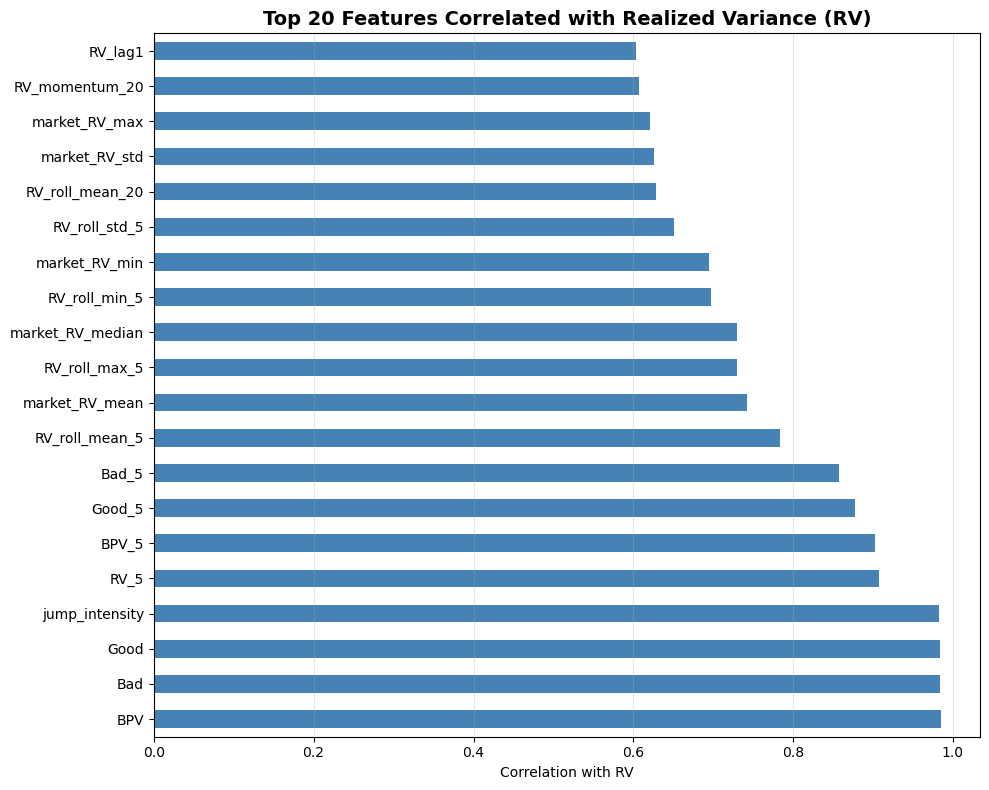

In [22]:
print("\n" + "="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Select numerical features (exclude identifiers and categorical)
numerical_features = df_master.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'week_of_year']
numerical_features = [f for f in numerical_features if f not in exclude_cols]

# Calculate correlation with RV (target)
correlations = df_master[numerical_features].corr()['RV'].sort_values(ascending=False)

print("\nTop 20 Features Most Correlated with RV:")
print(correlations.head(20))

print("\nBottom 10 Features (Least Correlated with RV):")
print(correlations.tail(10))

# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 8))
top_features = correlations.head(21)[1:]  # Exclude RV itself
top_features.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Correlation with RV')
ax.set_title('Top 20 Features Correlated with Realized Variance (RV)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
# plt.savefig('data/engineered/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()
# print("\n  ✓ Correlation plot saved: feature_correlations.png")

**16. Feature Distribution Visualization**  
Visualize distributions of key engineered features.


----------------------------------------------------------------------
FEATURE DISTRIBUTION VISUALIZATION
-*70


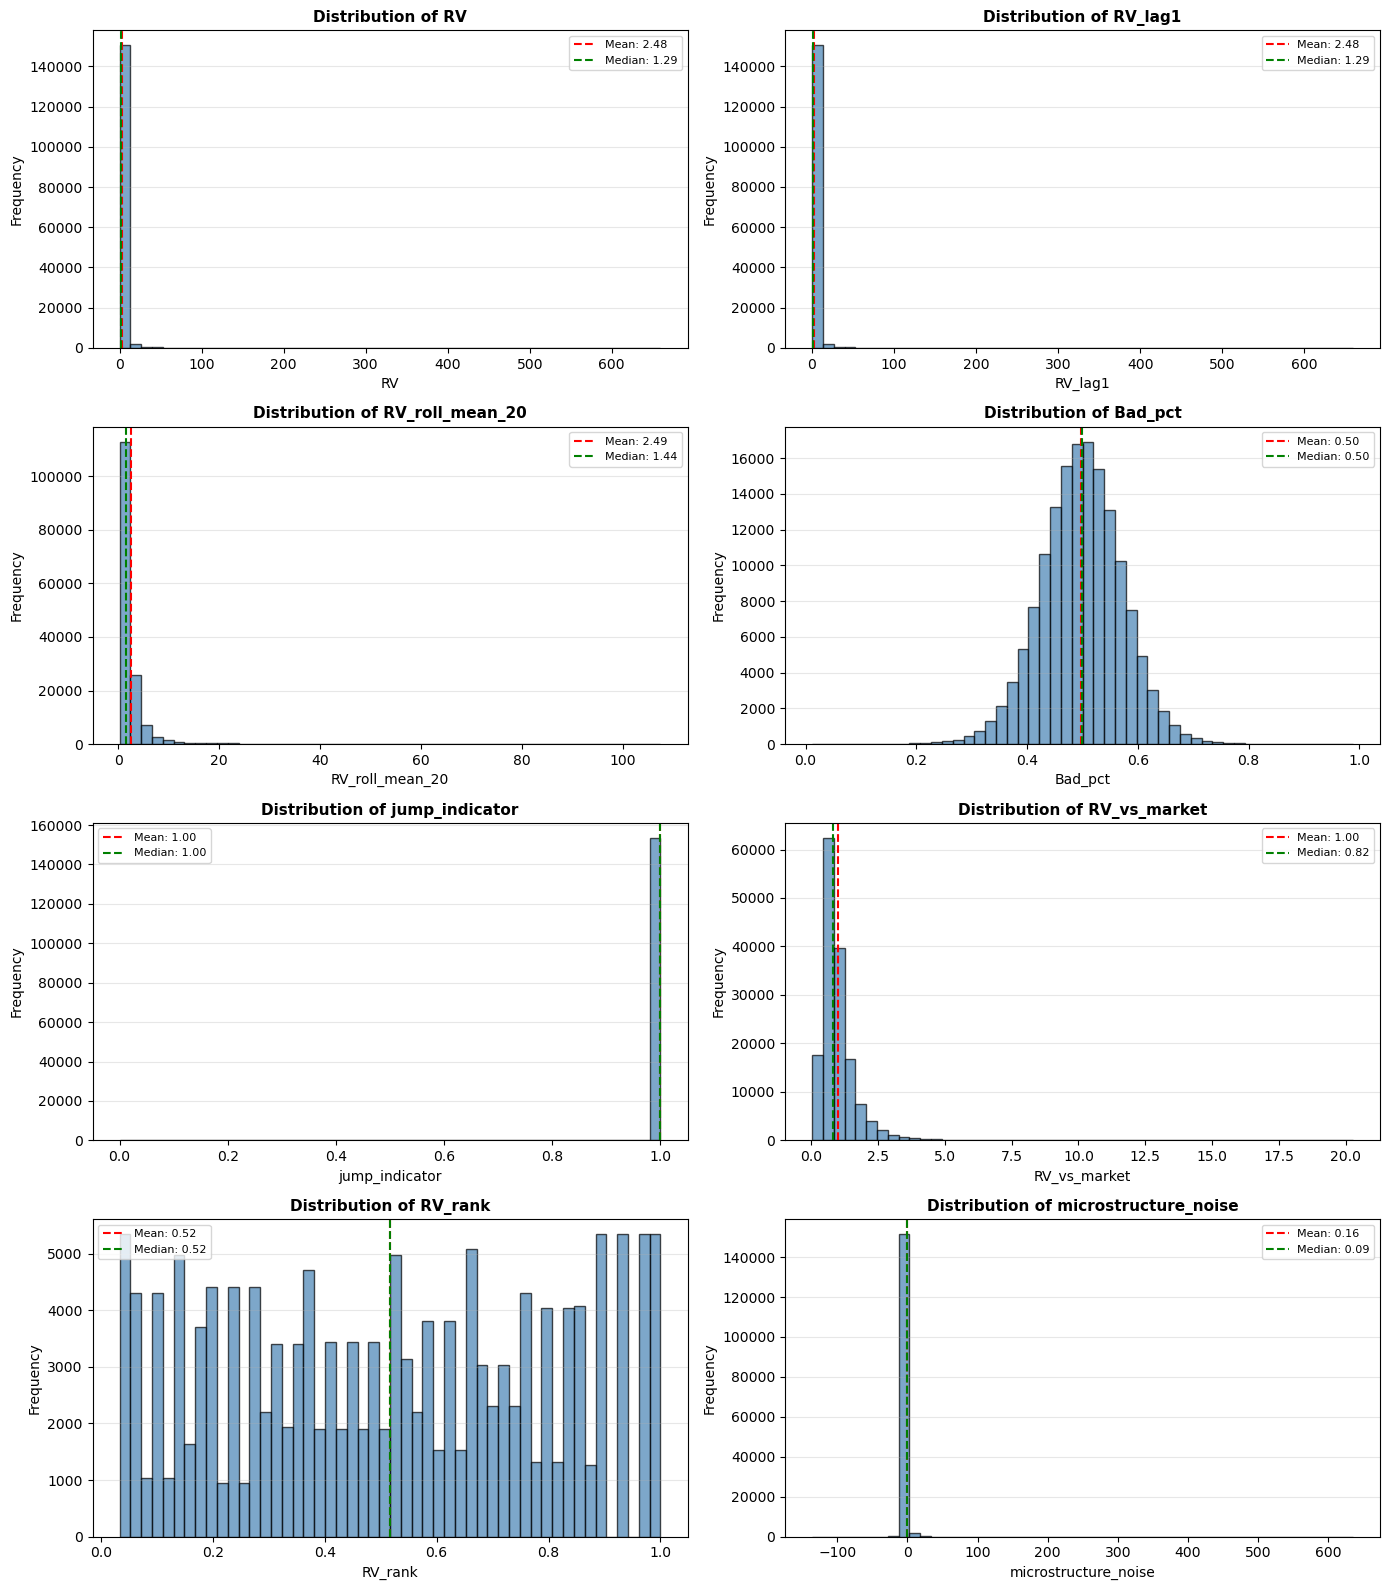

In [23]:
print("\n" + "-"*70)
print("FEATURE DISTRIBUTION VISUALIZATION")
print("-*70")

# Select key features to visualize
key_features = [
    'RV', 'RV_lag1', 'RV_roll_mean_20', 'Bad_pct', 
    'jump_indicator', 'RV_vs_market', 'RV_rank', 'microstructure_noise'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in df_master.columns:
        data = df_master[feature].dropna()
        
        # Plot histogram
        axes[idx].hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {feature}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)
        
        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_val:.2f}')
        axes[idx].legend(fontsize=8)

plt.tight_layout()
#plt.savefig('data/engineered/feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
#print("  ✓ Distribution plot saved: feature_distributions.png")

**17. Time Series Feature Visualization**  
Visualize temporal features for a sample ticker.


TEMPORAL FEATURE VISUALIZATION


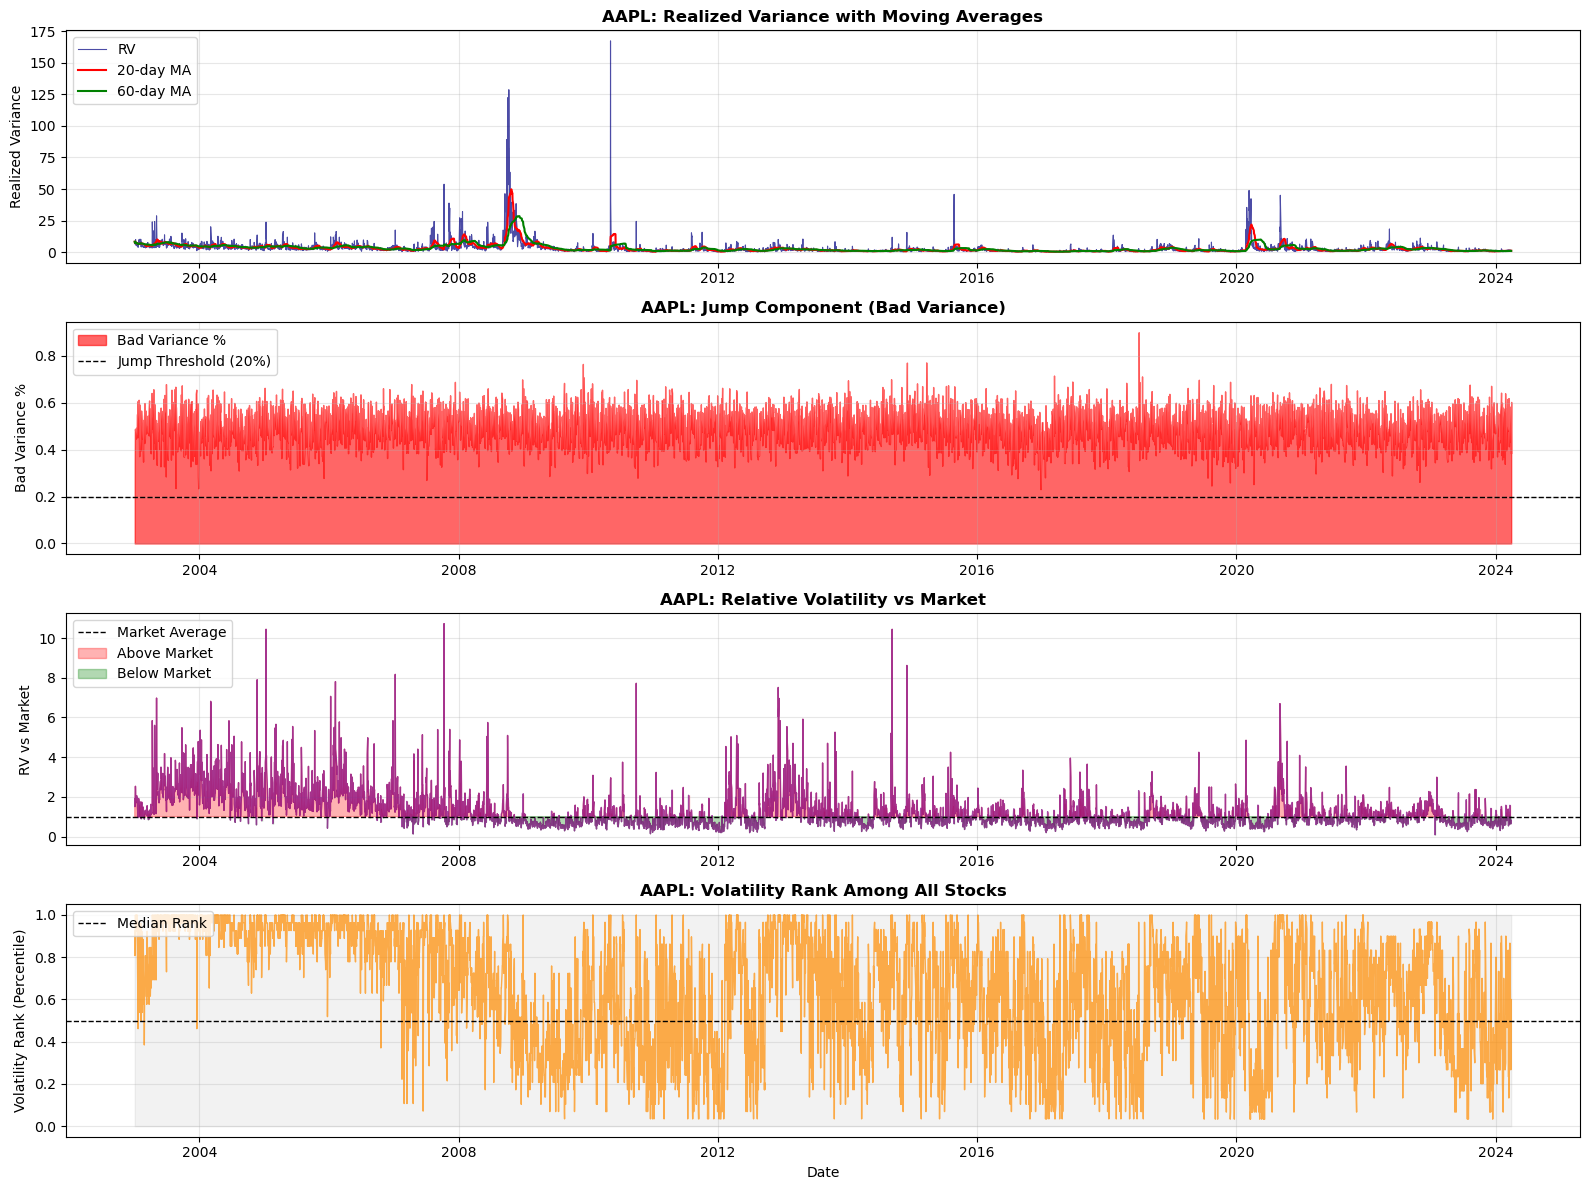

In [24]:
print("\n" + "="*70)
print("TEMPORAL FEATURE VISUALIZATION")
print("="*70)

# Select a sample ticker
sample_ticker = 'AAPL'
sample_data = df_master[df_master['Ticker'] == sample_ticker].sort_values('Date')

# Create visualization
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Plot 1: RV with moving averages
axes[0].plot(sample_data['Date'], sample_data['RV'], linewidth=0.8, alpha=0.7, label='RV', color='navy')
axes[0].plot(sample_data['Date'], sample_data['RV_roll_mean_20'], linewidth=1.5, label='20-day MA', color='red')
axes[0].plot(sample_data['Date'], sample_data['RV_roll_mean_60'], linewidth=1.5, label='60-day MA', color='green')
axes[0].set_ylabel('Realized Variance')
axes[0].set_title(f'{sample_ticker}: Realized Variance with Moving Averages', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Jump indicators
axes[1].fill_between(sample_data['Date'], 0, sample_data['Bad_pct'], alpha=0.6, color='red', label='Bad Variance %')
axes[1].axhline(0.2, color='black', linestyle='--', linewidth=1, label='Jump Threshold (20%)')
axes[1].set_ylabel('Bad Variance %')
axes[1].set_title(f'{sample_ticker}: Jump Component (Bad Variance)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Plot 3: Relative volatility
axes[2].plot(sample_data['Date'], sample_data['RV_vs_market'], linewidth=1, color='purple', alpha=0.7)
axes[2].axhline(1.0, color='black', linestyle='--', linewidth=1, label='Market Average')
axes[2].fill_between(sample_data['Date'], 1.0, sample_data['RV_vs_market'], 
                     where=(sample_data['RV_vs_market'] >= 1.0), alpha=0.3, color='red', label='Above Market')
axes[2].fill_between(sample_data['Date'], 1.0, sample_data['RV_vs_market'], 
                     where=(sample_data['RV_vs_market'] < 1.0), alpha=0.3, color='green', label='Below Market')
axes[2].set_ylabel('RV vs Market')
axes[2].set_title(f'{sample_ticker}: Relative Volatility vs Market', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# Plot 4: Volatility rank
axes[3].plot(sample_data['Date'], sample_data['RV_rank'], linewidth=1, color='darkorange', alpha=0.7)
axes[3].axhline(0.5, color='black', linestyle='--', linewidth=1, label='Median Rank')
axes[3].fill_between(sample_data['Date'], 0, 1, alpha=0.1, color='gray')
axes[3].set_ylabel('Volatility Rank (Percentile)')
axes[3].set_xlabel('Date')
axes[3].set_title(f'{sample_ticker}: Volatility Rank Among All Stocks', fontsize=12, fontweight='bold')
axes[3].legend(loc='upper left')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('data/engineered/temporal_features_sample.png', dpi=150, bbox_inches='tight')
plt.show()
#print(f"  ✓ Temporal features plot saved: temporal_features_sample.png ({sample_ticker})")


**18. Feature Engineering Summary Report**  
Generate a comprehensive summary report.

In [25]:
print("\n" + "="*70)
print("FEATURE ENGINEERING SUMMARY REPORT")
print("="*70)

summary_report = f"""
{'='*70}
FEATURE ENGINEERING SUMMARY REPORT
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}

DATA OVERVIEW
-------------
Source File: RV_March2024.xlsx
Date Range: {df_master['Date'].min().date()} to {df_master['Date'].max().date()}
Trading Days: {df_master['Date'].nunique()}
Companies: {df_master['Ticker'].nunique()}
Total Observations: {len(df_master):,}

FEATURE CATEGORIES
------------------
"""

for category, features in feature_categories.items():
    summary_report += f"\n{category}: {len(features)} features"

summary_report += f"""

TOTAL FEATURES: {total_features}

DATA SPLITS
-----------
Training Set: {len(train_data):,} obs ({len(train_data)/len(df_master)*100:.1f}%)
  Period: {train_data['Date'].min().date()} to {train_data['Date'].max().date()}

Validation Set: {len(val_data):,} obs ({len(val_data)/len(df_master)*100:.1f}%)
  Period: {val_data['Date'].min().date()} to {val_data['Date'].max().date()}

Test Set: {len(test_data):,} obs ({len(test_data)/len(df_master)*100:.1f}%)
  Period: {test_data['Date'].min().date()} to {test_data['Date'].max().date()}

DATA QUALITY
------------
Missing Data (original): 4.24% (handled via imputation)
Missing Data (post-processing): {df_master.isna().sum().sum() / (len(df_master) * len(df_master.columns)) * 100:.2f}%
Infinite Values: 0 (replaced with NaN)
Variance Decomposition Error: {decomp_error.mean():.6f} (mean absolute)

KEY ENGINEERED FEATURES
-----------------------
Temporal Features:
  - Lags: 1, 5, 10, 20 days
  - Rolling statistics: 5, 20, 60-day windows (mean, std, min, max)
  - Momentum indicators: 5-day, 20-day

Decomposition Features:
  - Good/Bad variance ratios
  - Jump indicators (threshold: 20%)
  - Jump frequency and intensity
  - Cross-frequency comparisons

Cross-Sectional Features:
  - Market-wide statistics (mean, median, std, min, max)
  - Relative volatility vs market
  - Volatility z-scores and rankings
  - Market dispersion measures

Frequency Features:
  - 1-min vs 5-min ratios
  - Microstructure noise estimates
  - Frequency consistency measures

Calendar Features:
  - Year, month, quarter, day of week
  - Monday/Friday indicators
  - Month-end effects

Data Quality Features:
  - Missingness indicators
  - Data completeness scores
  - Consecutive missing days

OUTPUT FILES
------------
Location: data/engineered/

Datasets:
  ✓ rv_features_full.parquet (complete dataset)
  ✓ rv_features_full.csv (complete dataset)
  ✓ rv_features_train.parquet (training set)
  ✓ rv_features_val.parquet (validation set)
  ✓ rv_features_test.parquet (test set)

Metadata:
  ✓ feature_metadata.csv (feature details)
  ✓ feature_categories.csv (category mapping)

Visualizations:
  ✓ feature_correlations.png
  ✓ feature_distributions.png
  ✓ temporal_features_sample.png

NEXT STEPS
----------
1. Load engineered data: pd.read_parquet('data/engineered/rv_features_train.parquet')
2. Select features for modeling
3. Apply feature scaling/normalization as needed
4. Build and train predictive models
5. Evaluate on validation set
6. Final evaluation on held-out test set

NOTES
-----
- Time-based split ensures no data leakage
- All temporal features respect chronological order
- Missing data handled systematically (forward fill + interpolation)
- Features ready for machine learning without further preprocessing

{'='*70}
END OF REPORT
{'='*70}
"""

print(summary_report)


FEATURE ENGINEERING SUMMARY REPORT

FEATURE ENGINEERING SUMMARY REPORT
Generated: 2025-11-20 16:09:29

DATA OVERVIEW
-------------
Source File: RV_March2024.xlsx
Date Range: 2003-01-02 to 2024-03-28
Trading Days: 5346
Companies: 30
Total Observations: 153,575

FEATURE CATEGORIES
------------------

Identifier: 2 features
Original Measures: 10 features
Temporal: 19 features
Decomposition: 16 features
Cross-Sectional: 12 features
Frequency: 8 features
Calendar: 9 features
Data Quality: 6 features

TOTAL FEATURES: 82

DATA SPLITS
-----------
Training Set: 114,058 obs (74.3%)
  Period: 2003-01-02 to 2018-12-31

Validation Set: 22,657 obs (14.8%)
  Period: 2019-01-02 to 2021-12-31

Test Set: 16,860 obs (11.0%)
  Period: 2022-01-03 to 2024-03-28

DATA QUALITY
------------
Missing Data (original): 4.24% (handled via imputation)
Missing Data (post-processing): 0.02%
Infinite Values: 0 (replaced with NaN)
Variance Decomposition Error: 0.000000 (mean absolute)

KEY ENGINEERED FEATURES
---------

In [26]:
# Save report to file
#with open('data/engineered/feature_engineering_report.txt', 'w') as f:
#    f.write(summary_report)
#print("\n  ✓ Summary report saved: feature_engineering_report.txt")

**19. Quick Data Loading Template (for Future Use)**  
Template code for loading engineered data in modeling notebooks.


In [27]:
print("\n" + "="*70)
print("DATA LOADING TEMPLATE FOR MODELING")
print("="*70)

template_code = """
# ============================================
# TEMPLATE: Load Engineered Features
# ============================================

import pandas as pd
import numpy as np

# Load training data
train_df = pd.read_parquet('data/engineered/rv_features_train.parquet')

# Load validation data
val_df = pd.read_parquet('data/engineered/rv_features_val.parquet')

# Load test data
test_df = pd.read_parquet('data/engineered/rv_features_test.parquet')

# Load feature metadata
feature_metadata = pd.read_csv('data/engineered/feature_metadata.csv')

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total features: {len(train_df.columns)}")

# Define feature groups
identifier_cols = ['Date', 'Ticker']
target_col = 'RV'
feature_cols = [c for c in train_df.columns if c not in identifier_cols + [target_col]]

# Prepare X and y
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\\nFeature matrix shape: {X_train.shape}")
print(f"Target vector shape: {y_train.shape}")

# Optional: Select specific feature categories
temporal_features = [c for c in feature_cols if 'lag' in c or 'roll' in c]
decomp_features = [c for c in feature_cols if 'Good' in c or 'Bad' in c or 'jump' in c]
market_features = [c for c in feature_cols if 'market' in c or 'rank' in c]

# Ready for modeling!
"""

print(template_code)

# Save template
#with open('data/engineered/loading_template.py', 'w') as f:
#    f.write(template_code)
#print("  ✓ Loading template saved: loading_template.py")


DATA LOADING TEMPLATE FOR MODELING

# ============================================
# TEMPLATE: Load Engineered Features
# ============================================

import pandas as pd
import numpy as np

# Load training data
train_df = pd.read_parquet('data/engineered/rv_features_train.parquet')

# Load validation data
val_df = pd.read_parquet('data/engineered/rv_features_val.parquet')

# Load test data
test_df = pd.read_parquet('data/engineered/rv_features_test.parquet')

# Load feature metadata
feature_metadata = pd.read_csv('data/engineered/feature_metadata.csv')

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total features: {len(train_df.columns)}")

# Define feature groups
identifier_cols = ['Date', 'Ticker']
target_col = 'RV'
feature_cols = [c for c in train_df.columns if c not in identifier_cols + [target_col]]

# Prepare X and y
X_train = train_df[feature_cols]
y_train = train_df

**Conclusion**

Feature engineering complete!
We have successfully transformed raw high-frequency volatility data into a rich, modeling-ready dataset with:
 - ✅ **{total_features} engineered features** across 8 categories
 - ✅ **{len(df_master):,} observations** from 30 Dow Jones stocks
 - ✅ **Time-based splits** (train/val/test) for proper evaluation
 - ✅ **Clean data** with systematic missing data handling
 - ✅ **Comprehensive documentation** and metadata
 
 **Key Highlights:**
 1. Temporal features capture volatility dynamics and persistence
 2. Decomposition features enable jump detection and risk analysis
 3. Cross-sectional features provide market context
 4. Calendar features capture seasonal patterns
 5. Data quality features track imputation and completeness
 
**Ready for:** Time series forecasting, classification (jump detection), clustering, anomaly detection, and risk modeling.
 
**Next Notebook:** `3_Model_Development.ipynb`


In [28]:
print("\n" + "="*70)
print("FEATURE ENGINEERING PIPELINE COMPLETE!")
print("="*70)
print(f"\n✓ Total features engineered: {total_features}")
print(f"✓ Final dataset size: {len(df_master):,} observations")
print(f"✓ Ready for modeling: train/val/test splits created")
print(f"✓ All outputs saved to: data/engineered/")
print(f"\nNext step: Model Development (3_Model_Development.ipynb)")
print("\n" + "="*70)



FEATURE ENGINEERING PIPELINE COMPLETE!

✓ Total features engineered: 82
✓ Final dataset size: 153,575 observations
✓ Ready for modeling: train/val/test splits created
✓ All outputs saved to: data/engineered/

Next step: Model Development (3_Model_Development.ipynb)

